<a href="https://colab.research.google.com/github/AugustinCablant/Stat-App/blob/main/MH_GIBBS_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### I. Implémentation de l'algorithme de MCMC

On considère des données simulées par la suite d'une matrice de cout Toeplitz, pour gérer les problèmes d'identiafibilité.

##### Import des packages

In [210]:
import numpy as np
import matplotlib.pyplot as plt
import ot
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


In [211]:
# niveau de bruit gaussien
sigma=0.04
np.random.seed(123)

# Fonction de rejet pour l'algorihtme de MH

def log_proba_rejet(u,v,W,x,y,Z,T):
    u1,v1,W1 = histogramme(u),histogramme(v),histogramme(W)
    x1,y1,Z1 = histogramme(x),histogramme(y),histogramme(Z)
    return 1/(2*sigma**2)*(np.linalg.norm(T-ot.emd(u1,v1,W1))**2-np.linalg.norm(T-ot.emd(x1,y1,Z1))**2)

#Prior sur les vecteurs de proba

def in_hypercube(u,v,f):

    if any(x < 0 or x > 1 for x in u):
        return False

    if any(x < 0 or x > 1 for x in v):
        return False

    if any(x < 0 or x>1 for x in f):
        return False
    return True

#Pour normaliser les vecteurs/matrices

def histogramme(x):
    # Normaliser la liste pour que la somme soit égale à 1
    somme = np.sum(x)
    histogramme = x / somme
    return histogramme

##### Passage d'un vecteur de coefficients à une matrice de Toeplizt avec une diagonale pénalisée à 10

In [212]:
def toeplitz_C(coefficients):
    coefficients=np.insert(coefficients, 0,10)
    n = len(coefficients) // 2 + 1
    matrix = [[0] * n for _ in range(n)]  # Créer une matrice vide de taille n*n

    # Remplir la première ligne
    for j in range(n):
        matrix[0][j] = coefficients[j]

    # Remplir la première colonne (sauf le premier élément)
    for i in range(1, n):
        matrix[i][0] = coefficients[n + i - 1]

    # Appliquer la structure de Toeplitz
    for i in range(1, n):
        for j in range(1, n):
            matrix[i][j] = matrix[i - 1][j - 1]

    return np.array(matrix)

#### Premier algorithme : Metropolis Hasting

In [213]:
np.random.seed(42)
def MH_gibbs(T,n = 5*10**5):
    N = len(T)
    # Initialisation
    U, V, f = np.zeros((n, N)), np.zeros((n, N)), np.zeros((n, 2*N-2))
    U[0] = np.random.uniform(size=N)
    V[0] = np.random.uniform(size=N)
    f[0] = np.random.uniform(size=2*N-2)
    # Vecteurs aléatoires
    e_u, e_v,e_f  = np.random.normal(0, 0.04, (N, n)), np.random.normal(0, 0.04, (N, n)), np.random.normal(0, 0.04, (2*N-2, n))
    u  = np.log(np.random.uniform(size=n))

    acceptance_rate = 0

    running_average_U = [U[0]]
    running_average_V = [V[0]]
    running_average_f = [f[0]]

    for k in range(n-1):
       
        # Pas pour U,V,W
        x, y, Z = U[k] + e_u[:, k], V[k]+e_v[:,k], f[k] + e_f[:, k]
        if not in_hypercube(x, y, Z): 
            U[k+1], V[k+1], f[k+1] = U[k], V[k], f[k]
        else:
            if u[k] < log_proba_rejet(U[k], V[k], toeplitz_C(f[k]), x, y, toeplitz_C(Z),T):
                U[k+1], V[k+1], f[k+1] = x, y, Z
                acceptance_rate += 1
            else:
                
                U[k+1], V[k+1], f[k+1] = U[k], V[k], f[k]

        # Calcul du running average
        running_average_U.append((k/(k+1))*running_average_U[k]+U[k+1]/(k+1))
        running_average_V.append((k/(k+1))*running_average_V[k]+V[k+1]/(k+1))
        running_average_f.append((k/(k+1))*running_average_f[k]+f[k+1]/(k+1))
    acceptance_rate /= n

    return U, V, f, acceptance_rate, running_average_U,running_average_V,running_average_f

#### Génération de données

On calcule à partir de vecteur de probabilité p,q et le vecteur f caractérisant une matrice de Toeplitz, la matrice de transport à laquelle on ajoute un bruit gaussien et les coefficients négatifs sont ramenés à 0 et on renormalise la matrice.

In [214]:
# Initialisation des données
np.random.seed(123)
p=np.array([0.2,0.25,0.3,0.15,0.1])
q = np.array([0.3,0.2,0.1,0.25,0.15])
f = np.array([0.13,0.85,0.76,0.26,0.50,0.45,0.65,0.17])

# Calcul du transport optimal 
T = ot.emd(p, q, toeplitz_C(f))

# Ajout de bruit gaussien à T
noise = np.random.normal(loc=0, scale=0.2, size=T.shape)
T_with_noise = T + noise
n=len(T_with_noise)
for i in range(n):
    T[i,i]=0
    for j in range(n):
        if T_with_noise[i,j]<0:
            T_with_noise[i,j]=0
T_with_noise=histogramme(T_with_noise)


# Simulation
U, V, F, acceptance_rate, running_average_U,running_average_V,running_average_C = MH_gibbs(T_with_noise)


print(f"Taux d'acceptation pour U : {acceptance_rate}")

Taux d'acceptation pour U : 0.222518


#### Normalisation des chaines de Markov pour visualisation

In [215]:
U = np.array([histogramme(vecteur) for vecteur in U])
V = np.array([histogramme(vecteur) for vecteur in V])
### création de la chaine de Markov C à partir de f mais pas très utile
C = np.array([histogramme(toeplitz_C(f)) for f in F])

#### Normalisation des running average pour observer la convergence

In [216]:
RA_U = np.array([histogramme(vecteur) for vecteur in running_average_U])
RA_V = np.array([histogramme(vecteur) for vecteur in running_average_V])
RA_f = np.array([histogramme(vecteur) for vecteur in running_average_C])

#### Plot des running average

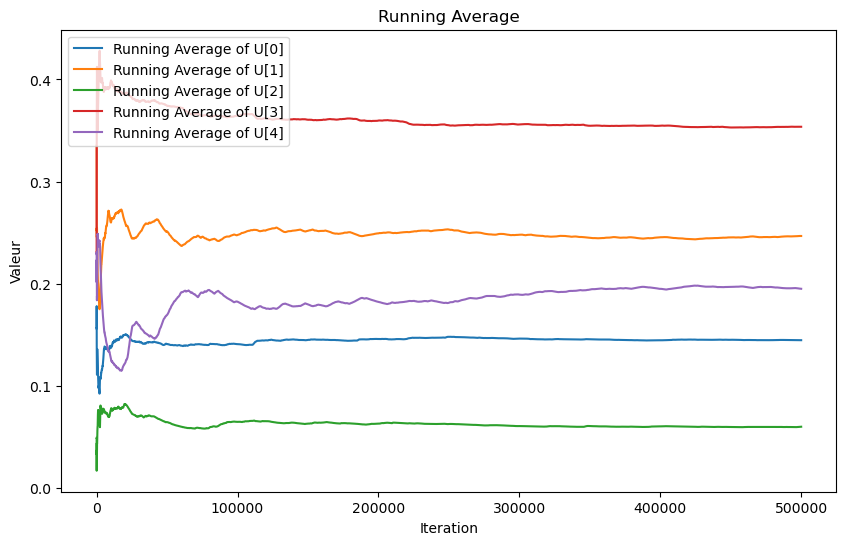

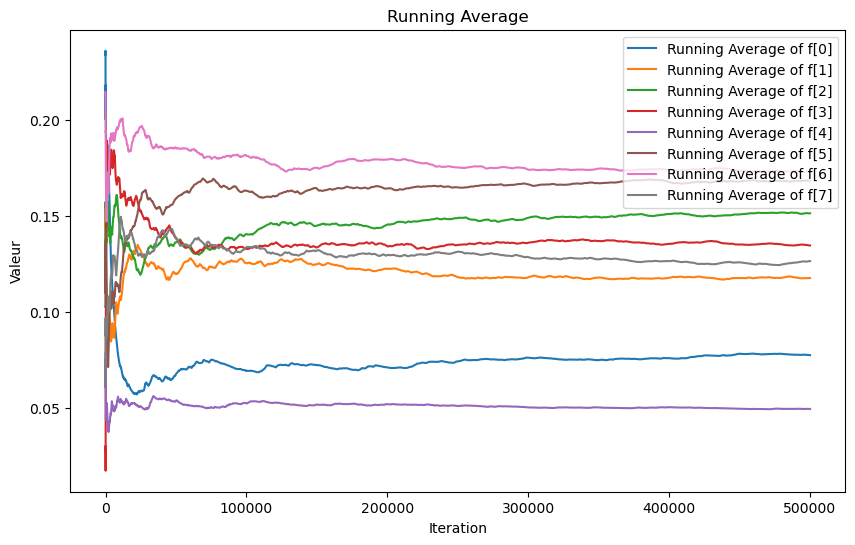

In [217]:
plt.figure(figsize=(10, 6))
for i in range(len(U[0])):
    plt.plot(list(range(len(RA_U))), [sample[i] for sample in RA_U], label=f'Running Average of U[{i}]')
plt.title("Running Average")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(len(F[0])):
    plt.plot(list(range(len(RA_f))), [sample[i] for sample in RA_f], label=f'Running Average of f[{i}]')
plt.title("Running Average")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()

#### Visualisation des posterior 

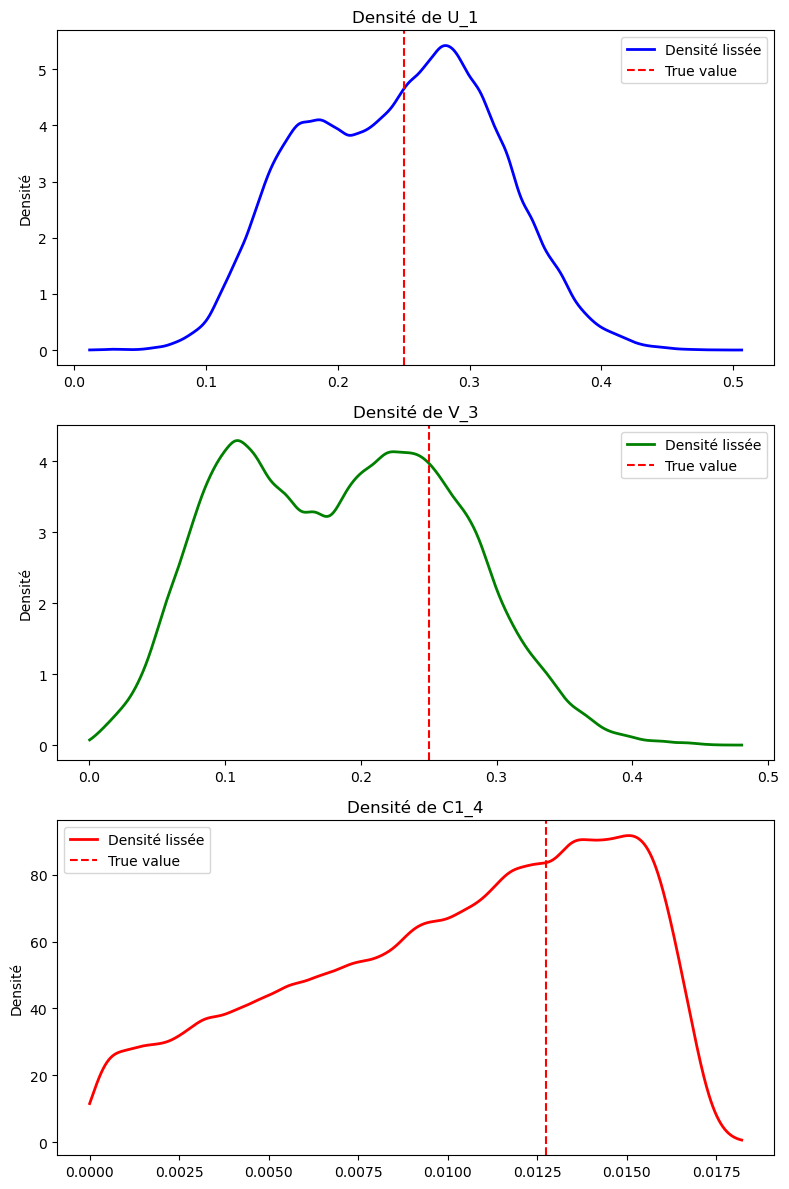

In [228]:
# Supposons que p, q et toeplitz_C(f) soient déjà définis

# Définition des ensembles U_3, V_3 et C1_2
U_1 = np.array([X[1] for X in U])
V_3 = np.array([X[3] for X in V])
C1_4 = np.array([X[1, 4] for X in C])

# Création des graphiques
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot pour U_3 avec axe vertical égal à p[2]
kde_U_3 = gaussian_kde(U_1)
x_U = np.linspace(min(U_1), max(U_1), 1000)
axs[0].plot(x_U, kde_U_3(x_U), color='blue', lw=2, label='Densité lissée')
axs[0].set_title('Densité de U_1')
axs[0].set_ylabel('Densité')
axs[0].axvline(x=p[1], color='red', linestyle='--', label='True value')
axs[0].legend()

# Plot pour V_3 avec axe vertical égal à q[2]
kde_V_3 = gaussian_kde(V_3)
x_V = np.linspace(min(V_3), max(V_3), 1000)
axs[1].plot(x_V, kde_V_3(x_V), color='green', lw=2, label='Densité lissée')
axs[1].set_title('Densité de V_3')
axs[1].set_ylabel('Densité')
axs[1].axvline(x=q[3], color='red', linestyle='--', label='True value')
axs[1].legend()

# Plot pour C1_2 avec axe vertical égal à toeplitz_C(f)[0, 1]
kde_C1_2 = gaussian_kde(C1_4)
x_C = np.linspace(min(C1_4), max(C1_4), 1000)
axs[2].plot(x_C, kde_C1_2(x_C), color='red', lw=2, label='Densité lissée')
axs[2].set_title('Densité de C1_4')
axs[2].set_ylabel('Densité')
axs[2].axvline(x=histogramme(toeplitz_C(f))[1,4], color='red', linestyle='--', label='True value')
axs[2].legend()

# Amélioration de l'affichage
plt.tight_layout()
plt.show()


### 2. Implémentation de l'algorithme de l'article

In [219]:
np.random.seed(42)
def MH_gibbs_2(T,n = 5*10**5):
    N = len(T)
    # Initialisation
    U, V, f = np.zeros((n, N)), np.zeros((n, N)), np.zeros((n, 2*N-2))
    U[0] = np.random.uniform(size=N)
    V[0] = np.random.uniform(size=N)
    f[0] = np.random.uniform(size=2*N-2)
    # Vecteurs aléatoires
    e_u, e_v,e_f  = np.random.normal(0, 0.04, (N, n)), np.random.normal(0, 0.04, (N, n)), np.random.normal(0, 0.04, (2*N-2, n))
    u_u, u_v, u_f  = np.log(np.random.uniform(size=n)),np.log(np.random.uniform(size=n)),np.log(np.random.uniform(size=n))

    acceptance_rate_u = 0
    acceptance_rate_v = 0
    acceptance_rate_f = 0
    
    running_average_U = [U[0]]
    running_average_V = [V[0]]
    running_average_f = [f[0]]

    for k in range(n-1):
       
        # Pas pour U
        x, y, Z = U[k] + e_u[:, k], V[k], f[k]
        if not in_hypercube(x, y, Z): 
            U[k+1], V[k+1], f[k+1] = U[k], V[k], f[k]
        else:
            if u_u[k] < log_proba_rejet(U[k], V[k], toeplitz_C(f[k]), x, y, toeplitz_C(Z),T):
                U[k+1], V[k+1], f[k+1] = x, y, Z
                acceptance_rate_u += 1
            else:
                
                U[k+1], V[k+1], f[k+1] = U[k], V[k], f[k]
        UK=U[k+1]
        #pas pour V
        x, y, Z = UK, V[k]+e_v[:,k], f[k] 
        if not in_hypercube(x, y, Z): 
            U[k+1], V[k+1], f[k+1] = UK, V[k], f[k]
        else:
            if u_v[k] < log_proba_rejet(UK, V[k], toeplitz_C(f[k]), x, y, toeplitz_C(Z),T):
                U[k+1], V[k+1], f[k+1] = x, y, Z
                acceptance_rate_v += 1
            else:
                U[k+1], V[k+1], f[k+1] = UK, V[k], f[k]
        VK=V[k+1]
        #Pas pour f
        x, y, Z = UK, VK, f[k] + e_f[:, k]
        if not in_hypercube(x, y, Z): 
            U[k+1], V[k+1], f[k+1] = UK, VK, f[k]
        else:
            if u_f[k] < log_proba_rejet(UK, VK, toeplitz_C(f[k]), x, y, toeplitz_C(Z),T):
                U[k+1], V[k+1], f[k+1] = x, y, Z
                acceptance_rate_f += 1
            else:
                
                U[k+1], V[k+1], f[k+1] = UK, VK, f[k]

        # Calcul du running average
        running_average_U.append((k/(k+1))*running_average_U[k]+U[k+1]/(k+1))
        running_average_V.append((k/(k+1))*running_average_V[k]+V[k+1]/(k+1))
        running_average_f.append((k/(k+1))*running_average_f[k]+f[k+1]/(k+1))
    acceptance_rate_u /= n
    acceptance_rate_v /= n
    acceptance_rate_f /= n

    return U, V, f, acceptance_rate_u,acceptance_rate_v,acceptance_rate_f, running_average_U,running_average_V,running_average_f

In [220]:
# Initialisation des données
np.random.seed(123)
p_ = np.array([0.2,0.25,0.3,0.15,0.1])
q_ = np.array([0.3,0.2,0.1,0.25,0.15])
f_ = np.array([0.13,0.85,0.76,0.26,0.50,0.45,0.65,0.17])

# Calcul du transport optimal 
T_ = ot.emd(p_, q_, toeplitz_C(f_))

# Ajout de bruit gaussien à T
noise = np.random.normal(loc=0, scale=0.2, size=T.shape)
T_with_noise_ = T_ + noise
n=len(T_with_noise)
for i in range(n):
    T[i,i]=0
    for j in range(n):
        if T_with_noise[i,j]<0:
            T_with_noise[i,j]=0
T_with_noise_=histogramme(T_with_noise_)


# Simulation
U_, V_, F_, acceptance_rate_u_,acceptance_rate_v_,acceptance_rate_f_, running_average_U_,running_average_V_,running_average_C_ = MH_gibbs_2(T_with_noise_)


print(f"Taux d'acceptation pour U : {acceptance_rate_u_}")
print(f"Taux d'acceptation pour V : {acceptance_rate_v_}")
print(f"Taux d'acceptation pour f : {acceptance_rate_f_}")

Taux d'acceptation pour U : 0.323532
Taux d'acceptation pour V : 0.479794
Taux d'acceptation pour f : 0.587824


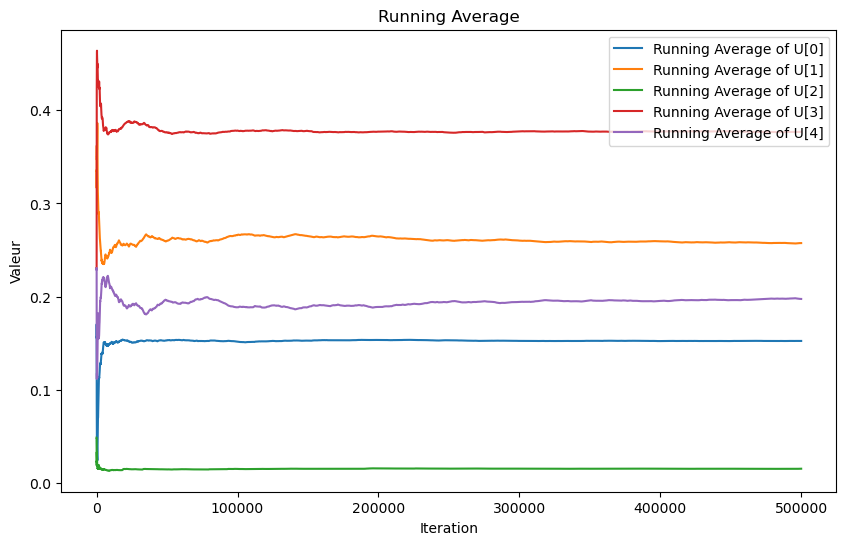

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


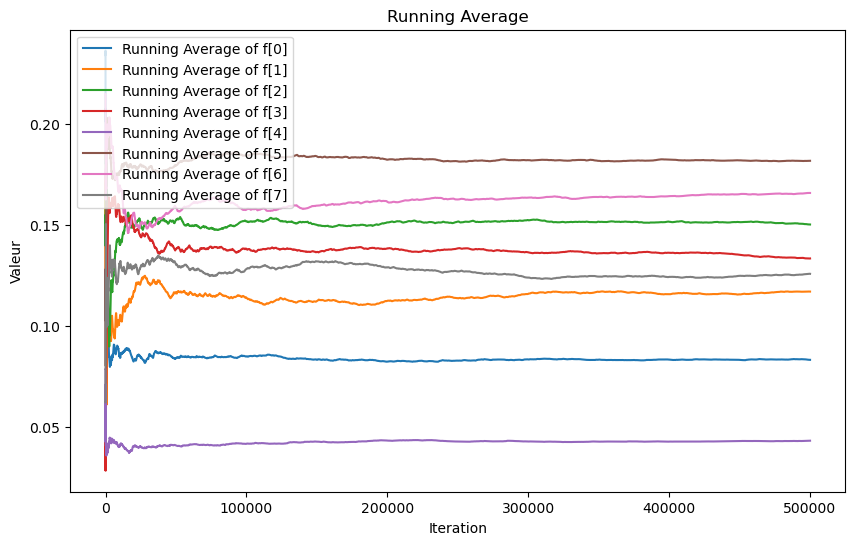

In [221]:
U_ = np.array([histogramme(vecteur) for vecteur in U_])
V_ = np.array([histogramme(vecteur) for vecteur in V_])
C_ = np.array([histogramme(toeplitz_C(f)) for f in F_])
RA_U_ = np.array([histogramme(vecteur) for vecteur in running_average_U_])
RA_V_ = np.array([histogramme(vecteur) for vecteur in running_average_V_])
RA_f_ = np.array([histogramme(vecteur) for vecteur in running_average_C_])

plt.figure(figsize=(10, 6))
for i in range(len(U[0])):
    plt.plot(list(range(len(RA_U_))), [sample[i] for sample in RA_U_], label=f'Running Average of U[{i}]')
plt.title("Running Average")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(len(F[0])):
    plt.plot(list(range(len(RA_f_))), [sample[i] for sample in RA_f_], label=f'Running Average of f[{i}]')
plt.title("Running Average")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()


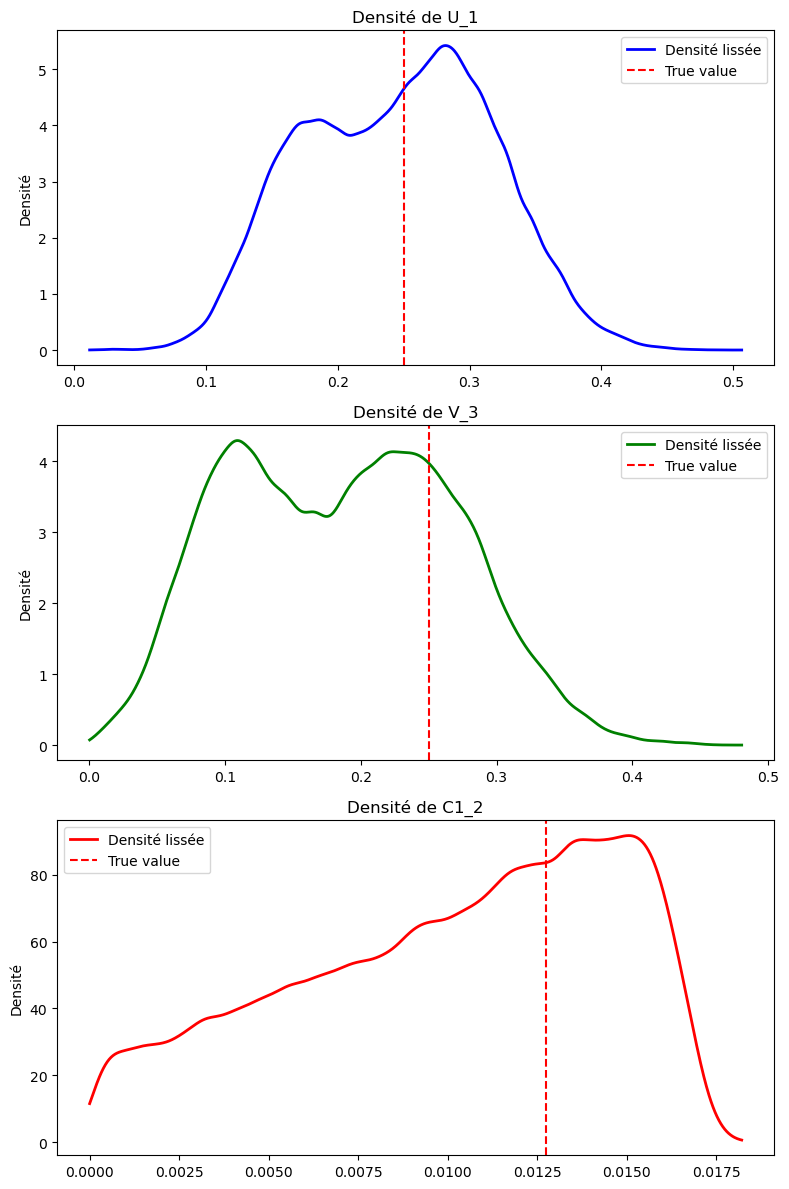

In [230]:
# Définition des ensembles U_3, V_3 et C1_2
U_1_ = np.array([X[1] for X in U])
V_3_ = np.array([X[3] for X in V])
C1_4_ = np.array([X[1, 4] for X in C])

# Création des graphiques
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Plot pour U_3 avec axe vertical égal à p[2]
kde_U_3 = gaussian_kde(U_1_)
x_U = np.linspace(min(U_1_), max(U_1_), 1000)
axs[0].plot(x_U, kde_U_3(x_U), color='blue', lw=2, label='Densité lissée')
axs[0].set_title('Densité de U_1')
axs[0].set_ylabel('Densité')
axs[0].axvline(x=p[1], color='red', linestyle='--', label='True value')
axs[0].legend()

# Plot pour V_3 avec axe vertical égal à q[2]
kde_V_3 = gaussian_kde(V_3_)
x_V = np.linspace(min(V_3_), max(V_3_), 1000)
axs[1].plot(x_V, kde_V_3(x_V), color='green', lw=2, label='Densité lissée')
axs[1].set_title('Densité de V_3')
axs[1].set_ylabel('Densité')
axs[1].axvline(x=q[3], color='red', linestyle='--', label='True value')
axs[1].legend()

# Plot pour C1_2 avec axe vertical égal à toeplitz_C(f)[0, 1]
kde_C1_2 = gaussian_kde(C1_4_)
x_C = np.linspace(min(C1_4_), max(C1_4_), 1000)
axs[2].plot(x_C, kde_C1_2(x_C), color='red', lw=2, label='Densité lissée')
axs[2].set_title('Densité de C1_2')
axs[2].set_ylabel('Densité')
axs[2].axvline(x=histogramme(toeplitz_C(f))[1,4], color='red', linestyle='--', label='True value')
axs[2].legend()

# Amélioration de l'affichage
plt.tight_layout()
plt.show()


In [ ]:
"""
# Trace plot pour U
plt.figure(figsize=(10, 6))
for i in range(len(U[0])):
    plt.plot(U[:, i], label=f"U[{i}]")
plt.title("Trace Plot pour U")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()

# Trace plot pour V
plt.figure(figsize=(10, 6))
for i in range(len(U[0])):
    plt.plot(V[:, i], label=f"V[{i}]")
plt.title("Trace Plot pour V")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(1,len(C[0])):
    plt.plot(C[:, i, 0], label=f"C[{i}][{1}]")
plt.title("Trace Plot pour C")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()
"""